# Vectorizing backpropagation (in theory)

Now that we understand how to work with the `Tensor` class in practice, it's high time that we pop the hood and remove all the screws. 

I have some good news and some bad news for you. The good news is that regarding the computational graph structure, `Tensor` works the same as `Scalar`. Our vectorized computatinal graphs are made up of `Tensor` nodes and `Edge` connections.

Bad news is that derivatives are way more complex than for our scalar counterparts. We need to significantly up our linear algebra game to keep the pace.

Let's get started.

## Vector-scalar graphs

As usual, let's see the simplest possible example: the dot product. For any $ \mathbf{x}, \mathbf{y} \in \mathbb{R}^n $, its dot product is defined by

$$
z = \mathbf{x} \cdot \mathbf{y} = \sum_{i=1}^{n} x_i y_i \in \mathbb{R}.
$$

In other words, we input two vectors (of the same dimensions) and receive a scalar value. Here's the graph:

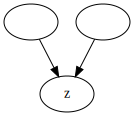

In [1]:
from graphviz import Digraph

graph = Digraph()
graph.node("a", "𝐱")
graph.node("b", "𝐲")
graph.node("c", "z")
graph.edges(["ac", "bc"])

graph

Nothing special so far. Now, let's calculate the derivative with backwards-mode differentiation! Following {ref}`what we've learned so far <section:computational-graphs/backwards-pass/backpropagation>`, this is the graph we need to fill with exact values:

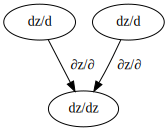

In [2]:
digraph = Digraph()

nodes = ["𝐱", "𝐲", "z"]
edges = [("𝐱", "z"), ("𝐲", "z")]

for v in nodes:
    digraph.node(v, f"dz/d{v}")

for u, v in edges:
    digraph.edge(u, v, f"∂{v}/∂{u}")

digraph

But what on earth do the symbols $ \frac{dz}{d\mathbf{x}} $ and $ \frac{\partial z}{\partial \mathbf{x}} $ mean? Can we take the derivative with respect to a vector?

Not so surprisingly, these represent

$$
\frac{dz}{d\mathbf{x}} = \bigg( \frac{dz}{dx_1}, \dots, \frac{dz}{dx_n} \bigg)
$$

and

$$
\frac{\partial z}{\partial \mathbf{x}} = \bigg( \frac{\partial z}{\partial x_1}, \dots, \frac{\partial z}{\partial x_n} \bigg),
$$

that is, we compressed a vector of derivatives into a single symbol. (In this example, the global derivative $ \frac{dz}{d\mathbf{x}} $ and the local derivative $ \frac{\partial z}{\partial \mathbf{x}} $ coincide. This won't be always the case.)

For the dot product, the vectorized derivatives are

$$
\begin{align*}
\frac{dz}{d\mathbf{x}} = \frac{\partial z}{\partial \mathbf{x}} &= (y_1, \dots, y_n), \\
\frac{dz}{d\mathbf{y}} = \frac{\partial z}{\partial \mathbf{y}} &= (x_1, \dots, x_n).
\end{align*}
$$

Sounds simple enough. What about vector-vector functions?

## Vector-vector graphs

Let's dial the difficulty up just a notch and consider the vector addition: for any $ \mathbf{x}, \mathbf{y} \in \mathbb{R}^n $, the expression

$$
\mathbf{z} = \mathbf{x} + \mathbf{y} \in \mathbb{R}^n
$$

defines the same V-shaped computational graph as dot product:

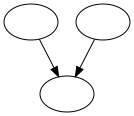

In [3]:
graph = Digraph()
graph.node("a", "𝐱")
graph.node("b", "𝐲")
graph.node("c", "𝐳")
graph.edges(["ac", "bc"])

graph

The derivative graph also looks the same, with one major difference: there are menacing vector-vector derivatives.

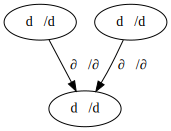

In [4]:
digraph = Digraph()

nodes = ["𝐱", "𝐲", "𝐳"]
edges = [("𝐱", "𝐳"), ("𝐲", "𝐳")]

for v in nodes:
    digraph.node(v, f"d𝐳/d{v}")

for u, v in edges:
    digraph.edge(u, v, f"∂{v}/∂{u}")

digraph

Fear not. It's a similar notational trick, encoding a *matrix* of derivatives:

$$
\frac{\partial \mathbf{z}}{\partial \mathbf{x}} = \begin{bmatrix}
\frac{\partial z_1}{\partial x_1} & \frac{\partial z_1}{\partial x_2} & \dots & \frac{\partial z_1}{\partial x_n} \\
\frac{\partial z_2}{\partial x_1} & \frac{\partial z_2}{\partial x_2} & \dots & \frac{\partial z_2}{\partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial z_n}{\partial x_1} & \frac{\partial z_n}{\partial x_2} & \dots & \frac{\partial z_n}{\partial x_n} \\
\end{bmatrix} \in \mathbb{R}^{n \times n}.
$$

The matrix $ \frac{\partial \mathbf{f}}{\partial \mathbf{x}} $ is called the *Jacobian* of $ \mathbf{f} $. It's an essential concept of differential calculus, and we'll frequently encounter it throughout our journey.

We can use a similar notation for the global derivatives as well:

$$
\frac{d \mathbf{z}}{d \mathbf{x}} = \begin{bmatrix}
\frac{d z_1}{d x_1} & \frac{d z_1}{d x_2} & \dots & \frac{d z_1}{d x_n} \\
\frac{d z_2}{d x_1} & \frac{d z_2}{d x_2} & \dots & \frac{d z_2}{d x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{d z_n}{d x_1} & \frac{d z_n}{d x_2} & \dots & \frac{d z_n}{d x_n} \\
\end{bmatrix} \in \mathbb{R}^{n \times n}.
$$

Following our notational conventions, let's call $ \frac{\partial \mathbf{z}}{\partial \mathbf{x}} $ the *local* Jacobian, while $ \frac{d\mathbf{f}}{d\mathbf{x}} $ the *global* Jacobian.

Let's make the definitions precise.

````{prf:definition} The Jacobian
Let $ \mathbf{y}: \mathbb{R}^n \to \mathbb{R}^m $ be an $ n $-variable function mapping $ \mathbf{x} \in \mathbb{R}^n $ to $ \mathbf{y} \in \mathbb{R}^m $.

The Jacobian of $ f $ is defined by the matrix

$$
\frac{\partial \mathbf{y}}{\partial \mathbf{x}} = \begin{bmatrix}
\frac{\partial y_1}{\partial x_1} & \frac{\partial y_1}{\partial x_2} & \dots & \frac{\partial y_1}{\partial x_n} \\
\frac{\partial y_2}{\partial x_1} & \frac{\partial y_2}{\partial x_2} & \dots & \frac{\partial y_2}{\partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial y_m}{\partial x_1} & \frac{\partial y_m}{\partial x_2} & \dots & \frac{\partial y_m}{\partial x_n} \\
\end{bmatrix} \in \mathbb{R}^{m \times n}.
$$
````

Note that when the input and output dimensions don't match, the Jacobian is *not* a square matrix. The dimension of the Jacobian is the output dimension times input dimension.

## The vectorized chain rule

Now that we understand the building blocks of vectorized computational graphs, let's focus on the lead actor: the chain rule. Like always, it's best to study it through an example. You already know the drill by now, so let's start with the graph right away.

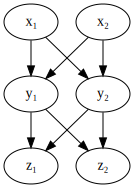

In [5]:
digraph = Digraph()

nodes = ["x₁", "x₂", "y₁", "y₂", "z₁", "z₂"]
edges = [("x₁", "y₁"), ("x₁", "y₂"),
         ("x₂", "y₁"), ("x₂", "y₂"),
         ("y₁", "z₁"), ("y₁", "z₂"),
         ("y₂", "z₁"), ("y₂", "z₂")]

for v in nodes:
    digraph.node(v)

digraph.edges(edges)

digraph

Let's compute the derivative! Right away, we hit a snag. Unlike our previous examples, there's not one, but two terminal nodes! Thus, we have two derivative graphs to fill up with values.

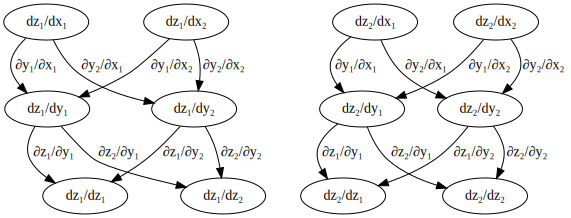

In [6]:
digraph = Digraph()

nodes = ["x₁", "x₂", "y₁", "y₂", "z₁", "z₂"]
edges = [("x₁", "y₁"), ("x₁", "y₂"),
         ("x₂", "y₁"), ("x₂", "y₂"),
         ("y₁", "z₁"), ("y₁", "z₂"),
         ("y₂", "z₁"), ("y₂", "z₂")]
offset = " "

for v in nodes:
    digraph.node(v, label=f"dz₁/d{v}")
    digraph.node(v + offset, label=f"dz₂/d{v}")

for u, v in edges:
    digraph.edge(u, v, label=f"∂{v}/∂{u}")
    digraph.edge(u + offset, v + offset, label=f"∂{v}/∂{u}")

digraph

According to what we've learned when {ref}`we introduced backpropagation <section:computational-graphs/backwards-pass/backpropagation>`, the first graph gives

$$
\begin{align*}
\frac{dz_1}{dx_1} &= \frac{dz_1}{dy_1} \frac{\partial y_1}{\partial x_1} + \frac{dz_1}{dy_2} \frac{\partial y_2}{\partial x_1}, \\
\frac{dz_1}{dx_2} &= \frac{dz_1}{dy_1} \frac{\partial y_1}{\partial x_2} + \frac{dz_1}{dy_2} \frac{\partial y_2}{\partial x_2},
\end{align*}
$$

while the second graph gives

$$
\begin{align*}
\frac{dz_2}{dx_1} &= \frac{dz_2}{dy_1} \frac{\partial y_1}{\partial x_1} + \frac{dz_2}{dy_2} \frac{\partial y_2}{\partial x_1}, \\
\frac{dz_2}{dx_2} &= \frac{dz_2}{dy_1} \frac{\partial y_1}{\partial x_2} + \frac{dz_2}{dy_2} \frac{\partial y_2}{\partial x_2}.
\end{align*}
$$

So many symbols and operations; it's not the most pleasant sights to look at. Do you recognize a pattern? Let me rewrite the above expressions in a matrix form:

$$
\begin{bmatrix}
\frac{dz_1}{dx_1} & \frac{dz_1}{dx_2} \\
\frac{dz_2}{dx_1} & \frac{dz_2}{dx_2} \\
\end{bmatrix} = \begin{bmatrix}
\sum_{k=1}^2 \frac{dz_1}{dy_k} \frac{\partial y_k}{\partial x_1} & \sum_{k=1}^2 \frac{dz_1}{dy_k} \frac{\partial y_k}{\partial x_2} \\
\sum_{k=1}^2 \frac{dz_2}{dy_k} \frac{\partial y_k}{\partial x_1} & \sum_{k=1}^2 \frac{dz_2}{dy_k} \frac{\partial y_k}{\partial x_2} \\
\end{bmatrix}.
$$

In other words,

$$
\frac{d\mathbf{z}}{d\mathbf{x}} = \frac{d\mathbf{z}}{d\mathbf{y}} \frac{\partial \mathbf{y}}{\partial \mathbf{x}}
$$

holds! With one brilliant stroke of linear algebra, we've contracted our computational graph from

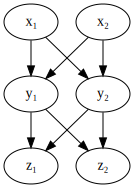

In [7]:
digraph = Digraph()

nodes = ["x₁", "x₂", "y₁", "y₂", "z₁", "z₂"]
edges = [("x₁", "y₁"), ("x₁", "y₂"),
         ("x₂", "y₁"), ("x₂", "y₂"),
         ("y₁", "z₁"), ("y₁", "z₂"),
         ("y₂", "z₁"), ("y₂", "z₂")]

for v in nodes:
    digraph.node(v)

digraph.edges(edges)

digraph

to

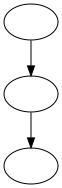

In [8]:
digraph = Digraph()

nodes = ["𝐱", "𝐲", "𝐳"]
edges = [("𝐱", "𝐲"), ("𝐲", "𝐳")]

for v in nodes:
    digraph.node(v)

for u, v in edges:
    digraph.edge(u, v)

digraph

where $ \mathbf{x}, \mathbf{y}, \mathbf{z} \in \mathbb{R}^2 $, and its derivative graphs from

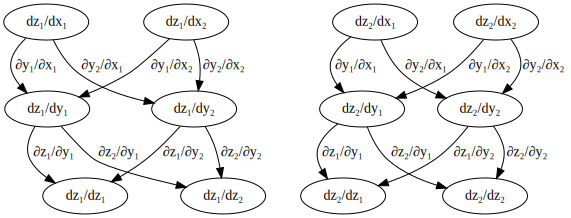

In [9]:
digraph = Digraph()

nodes = ["x₁", "x₂", "y₁", "y₂", "z₁", "z₂"]
edges = [("x₁", "y₁"), ("x₁", "y₂"),
         ("x₂", "y₁"), ("x₂", "y₂"),
         ("y₁", "z₁"), ("y₁", "z₂"),
         ("y₂", "z₁"), ("y₂", "z₂")]
offset = " "

for v in nodes:
    digraph.node(v, label=f"dz₁/d{v}")
    digraph.node(v + offset, label=f"dz₂/d{v}")

for u, v in edges:
    digraph.edge(u, v, label=f"∂{v}/∂{u}")
    digraph.edge(u + offset, v + offset, label=f"∂{v}/∂{u}")

digraph

to

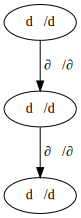

In [10]:
digraph = Digraph()

nodes = ["𝐱", "𝐲", "𝐳"]
edges = [("𝐱", "𝐲"), ("𝐲", "𝐳")]

for v in nodes:
    digraph.node(v, f"d𝐳/d{v}")

for u, v in edges:
    digraph.edge(u, v, f"∂{v}/∂{u}")

digraph

where $ \frac{d\mathbf{z}}{d\mathbf{x}}, \frac{d\mathbf{z}}{d\mathbf{y}}, \frac{d\mathbf{z}}{d\mathbf{z}}, \frac{\partial \mathbf{y}}{\partial \mathbf{x}}, \frac{\partial \mathbf{z}}{\partial \mathbf{y}} \in \mathbb{R}^{2 \times 2} $ are $ 2 \times 2 $ matrices. That's a massive improvement! I told you that linear algebra is powerful.

Going one step further, consider the vectorized computational graph defined by $ \mathbf{x} \in \mathbb{R}^n, \mathbf{y} \in \mathbb{R}^m, \mathbf{z} \in \mathbb{R}^k, $ and $ \mathbf{w} \in \mathbb{R}^l $:

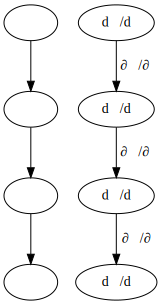

In [11]:
digraph = Digraph()

nodes = ["𝐱", "𝐲", "𝐳", "𝐰"]
edges = [("𝐱", "𝐲"), ("𝐲", "𝐳"), ("𝐳", "𝐰")]

offset = " "

for v in nodes:
    digraph.node(v + offset, v)
    digraph.node(v, f"d𝐰/d{v}")

for u, v in edges:
    digraph.edge(u + offset, v + offset)
    digraph.edge(u, v, f"∂{v}/∂{u}")

digraph

(For simplicity, I have put the graph and its derivative graph onto the same figure.) In this case, the Jacobians have various dimensions:

$$
\frac{d\mathbf{w}}{d\mathbf{x}} \in \mathbb{R}^{l \times n}, \quad \frac{d\mathbf{w}}{d\mathbf{y}} \in \mathbb{R}^{l \times m}, \quad \frac{d\mathbf{w}}{d\mathbf{z}} \in \mathbb{R}^{l \times k}, \quad \frac{d\mathbf{w}}{d\mathbf{w}} \in \mathbb{R}^{l \times l},
$$

and

$$
\frac{\partial \mathbf{y}}{\partial \mathbf{x}} \in \mathbb{R}^{m \times n}, \quad \frac{\partial \mathbf{z}}{\partial \mathbf{y}} \in \mathbb{R}^{k \times m}, \quad \frac{\partial \mathbf{w}}{\partial \mathbf{z}} \in \mathbb{R}^{l \times k}.
$$

According to the chain rule,

$$
\begin{align*}
\frac{d\mathbf{w}}{d\mathbf{x}} &= \frac{d\mathbf{w}}{d\mathbf{y}} \frac{\partial \mathbf{y}}{\partial \mathbf{x}} \\
&= \frac{d\mathbf{w}}{d\mathbf{z}} \frac{\partial \mathbf{z}}{\partial \mathbf{y}} \frac{\partial \mathbf{y}}{\partial \mathbf{x}} \\
&= \frac{d\mathbf{w}}{d\mathbf{w}} \frac{\partial \mathbf{w}}{\partial \mathbf{z}} \frac{\partial \mathbf{z}}{\partial \mathbf{y}} \frac{\partial \mathbf{y}}{\partial \mathbf{x}}.
\end{align*}
$$

One more step. Now that we've dealt with vectorized computational graphs that consist of one path, it's time to add some twists and forks. Take a look at the next graph, one that we've seen before:

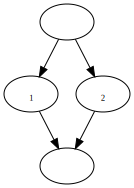

In [12]:
digraph = Digraph()

nodes = ["𝐱", "𝐲₁", "𝐲₂", "𝐳"]
edges = [("𝐱", "𝐲₁"), ("𝐱", "𝐲₂") ,
         ("𝐲₁", "𝐳"), ("𝐲₂", "𝐳")]

for v in nodes:
    digraph.node(v)

for u, v in edges:
    digraph.edge(u, v)

digraph

Here, the chain rule says that

$$
\frac{d\mathbf{z}}{d\mathbf{x}} = \frac{d\mathbf{z}}{d\mathbf{y}_1} \frac{\partial \mathbf{y}_1}{\partial \mathbf{x}} + \frac{d\mathbf{z}}{d\mathbf{y}_2} \frac{\partial \mathbf{y}_2}{\partial \mathbf{x}}.
$$

In theory, the vectorized backpropagation works the same as its vanilla counterpart, with matrices instead of scalars. Are we ready to roll with the implementation?

See you in the next chapter!